In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from lmfit.models import SineModel
from scipy.optimize import curve_fit
from typing import Optional
import sympy as sp
from sympy.plotting import plot3d
from components import point2d as p2
from components import point3d as p3
from components import antennaPair as antp
from components import antenna as ant
import itertools
%matplotlib inline

### Constants

In [2]:
c = 2.998e8 #光の速度
f = 920.4e6 #周波数
WAVE_LENGTH = c / f * 100 #理論波長
THETA_M = 34 * np.pi / 180
MAX_L = WAVE_LENGTH / (2 * np.sin(THETA_M))
L = 25
print(f'波長λ:{WAVE_LENGTH}, Lの最大値:{MAX_L}')
R=45

波長λ:32.57279443720122, Lの最大値:29.124828154140907


In [3]:
TARGET_TAG = "E200 4216 0560 6410 02BC E14A"

In [4]:
main_df = pd.DataFrame(columns=["tagId","antenna","timestamp","frequency","doppler","rssi","phase","samplingNumber", "dataType",])

### Get Data

In [5]:
data_dir = "../data/"

file_name_list = [
    "aoa_0_aln-9840",
    "aoa_10_aln-9840",
    "aoa_20_aln-9840",
    "aoa_30_aln-9840",
    "aoa_40_aln-9840",
    "aoa_50_aln-9840",
    "aoa_60_aln-9840",
    "aoa_70_aln-9840",
    "aoa_80_aln-9840",
    "aoa_90_aln-9840",
    "aoa_100_aln-9840",
    "aoa_110_aln-9840",
    "aoa_120_aln-9840",
    "aoa_130_aln-9840",
    "aoa_140_aln-9840",
]

data_dict = {}
data_dict = dict(zip(file_name_list, [pd.read_csv(data_dir + file + ".csv") for file in file_name_list]))

### Culculating AoA

In [6]:
def cul_aoa(phase_diff_df:pd.DataFrame):
    return phase_diff_df.map(
        lambda x: np.arcsin(WAVE_LENGTH / (4 * np.pi * L) * x) * 180 / np.pi
    )

### Culculating Actual AoA

In [7]:
def cul_actual_aoa(H:float, df:pd.DataFrame):
    return df["dataType"].map(lambda x: np.degrees(np.arctan(float(x.split("_")[1]) / H)))

### Data Formatting

In [8]:
delta_phi_0 = 0

for key, df in data_dict.items():
    df["dataType"] = key
    df["x"] = df["dataType"].map(lambda x: float(x.split("_")[1]))
    df = df[df["tagId"] == TARGET_TAG]
    df.set_index("samplingNumber", inplace=True)
    df1 = df[df["antenna"] == 1].rename(columns={"phase": "antenna1.phase", "rssi": "antenna1.rssi", "timestamp": "antenna1.timestamp", "doppler": "antenna1.doppler",})
    df2 = df[df["antenna"] == 2].rename(columns={"phase": "antenna2.phase", "rssi": "antenna2.rssi", "timestamp": "antenna2.timestamp", "doppler": "antenna2.doppler",})
    df = pd.concat([df1, df2[["antenna2.timestamp", "antenna2.phase", "antenna2.rssi", "antenna2.doppler"]]], axis=1)
    df["phaseDiff"] = df["antenna2.phase"]-df["antenna1.phase"]
    df["actualAoA"] = cul_actual_aoa(H=216.05, df=df)
    data_dict[key] = df[:100]

delta_phi_0 = data_dict["aoa_0_aln-9840"]["phaseDiff"].mean()

for key,df in data_dict.items():
    df["phaseDiff"] = df["phaseDiff"] - delta_phi_0
    df["AoA"] = cul_aoa(df["phaseDiff"])

data_dict["aoa_140_aln-9840"].tail()

,tagId,antenna,antenna1.timestamp,frequency,antenna1.doppler,antenna1.rssi,antenna1.phase,dataType,x,antenna2.timestamp,antenna2.phase,antenna2.rssi,antenna2.doppler,phaseDiff,actualAoA,AoA
samplingNumber,,,,,,,,,,,,,,,,
95,E200 4216 0560 6410 02BC E14A,1,1713341571563144,920.4,-11.375,-61.5,0.319068,aoa_140_aln-9840,140.0,1713341571675467,5.957981,-65.0,8.1250,8.249594,32.943163,58.797083
96,E200 4216 0560 6410 02BC E14A,1,1713341572560811,920.4,6.500,-62.0,0.276117,aoa_140_aln-9840,140.0,1713341572671726,6.099108,-65.5,-47.1875,8.433671,32.943163,60.976821
97,E200 4216 0560 6410 02BC E14A,1,1713341573562224,920.4,1.625,-62.0,0.245437,aoa_140_aln-9840,140.0,1713341573674649,6.037748,-64.5,-6.5000,8.402992,32.943163,60.603356
98,E200 4216 0560 6410 02BC E14A,1,1713341574569862,920.4,6.500,-61.5,0.214757,aoa_140_aln-9840,140.0,1713341574681429,6.111379,-65.0,-37.3750,8.507303,32.943163,61.891594
99,E200 4216 0560 6410 02BC E14A,1,1713341575558672,920.4,1.625,-62.0,0.239301,aoa_140_aln-9840,140.0,1713341575674985,6.037748,-65.0,-19.5000,8.409128,32.943163,60.677702


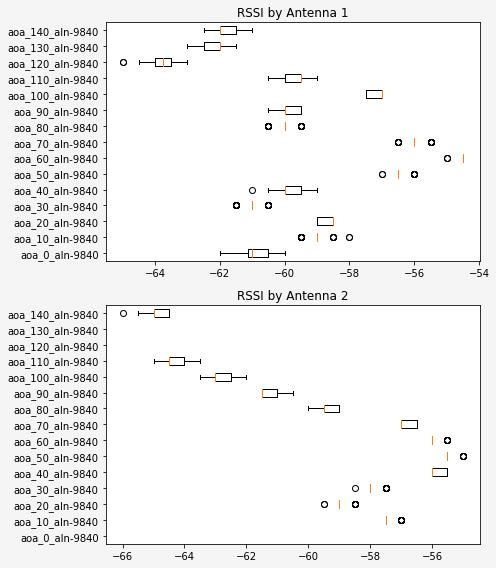

In [9]:
fig, axes = plt.subplots(2, 1, tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=7, h=8)
antenna1_data = [df["antenna1.rssi"].to_list() for df in data_dict.values()]
antenna2_data = [df["antenna2.rssi"].to_list() for df in data_dict.values()]
axes[0].boxplot(antenna1_data, labels=data_dict.keys(), vert=False)
axes[0].set_title("RSSI by Antenna 1")
axes[1].boxplot(antenna2_data, labels=data_dict.keys(), vert=False)
axes[1].set_title("RSSI by Antenna 2")
plt.show()

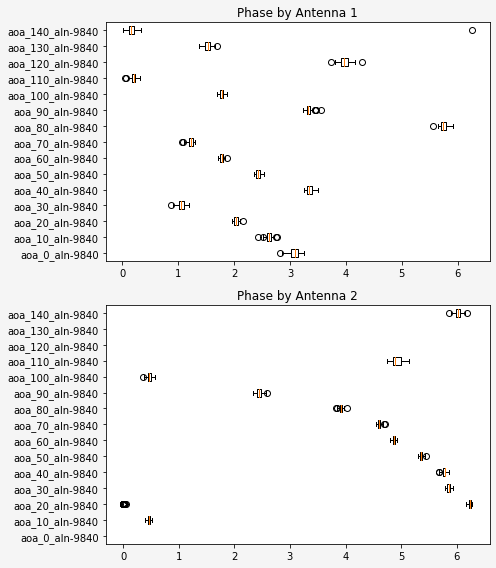

In [10]:
fig, axes = plt.subplots(2, 1, tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=7, h=8)
antenna1_data = [df["antenna1.phase"].to_list() for df in data_dict.values()]
antenna2_data = [df["antenna2.phase"].to_list() for df in data_dict.values()]
axes[0].boxplot(antenna1_data, labels=data_dict.keys(), vert=False)
axes[0].set_title("Phase by Antenna 1")
axes[1].boxplot(antenna2_data, labels=data_dict.keys(), vert=False)
axes[1].set_title("Phase by Antenna 2")
plt.show()

Text(0.5, 1.0, 'Phase Diff')

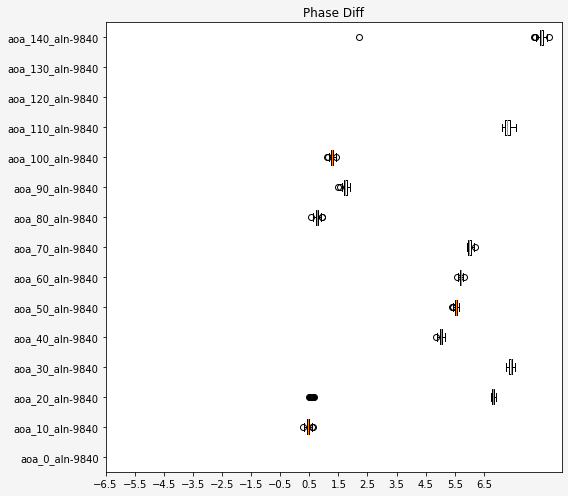

In [11]:
fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=8, h=7)
phase_diff_data = [df["phaseDiff"].to_list() for df in data_dict.values()]
ax.boxplot(phase_diff_data, labels=data_dict.keys(), vert=False)
ax.set_xticks(np.arange(-6.5, 6.6, step=1.0))
ax.set_title("Phase Diff")

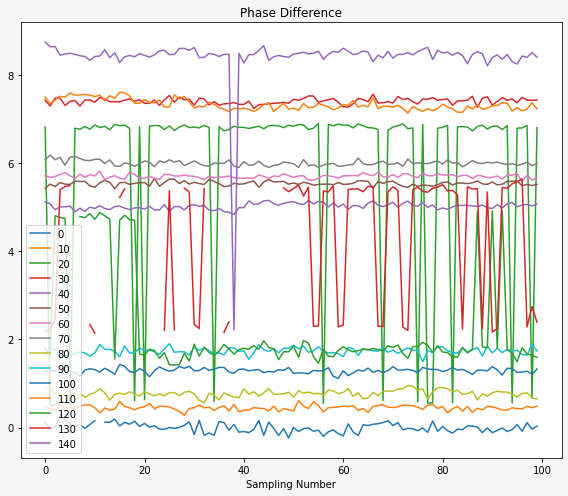

In [12]:
fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=8, h=7)
for key, df in data_dict.items():
    ax.plot(df["phaseDiff"], label=key.split("_")[1])
# ax.set_yticks(np.arange(-6.5, 6.6, step=1.0))
ax.set_title("Phase Difference")
ax.set_xlabel("Sampling Number")
ax.legend()
plt.show()

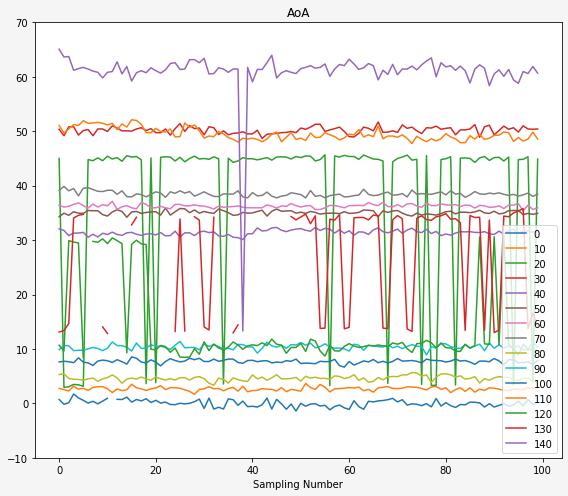

In [13]:
fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=8, h=7)
for key, df in data_dict.items():
    ax.plot(df["AoA"], label=key.split("_")[1])
ax.set_yticks(np.arange(-10, 80, step=10))
ax.set_title("AoA")
ax.set_xlabel("Sampling Number")
ax.legend()
plt.show()

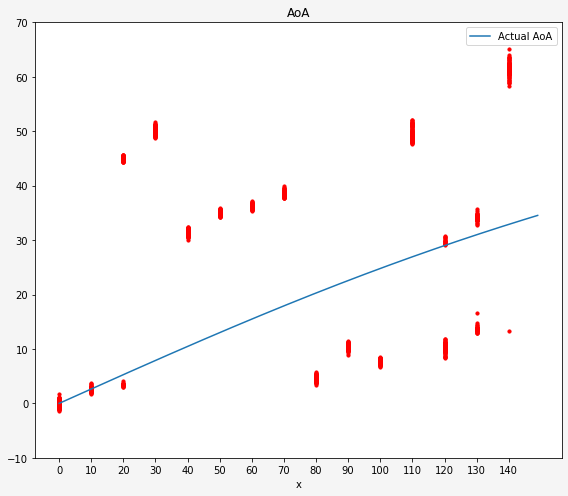

In [14]:
fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=8, h=7)
x = np.arange(0, 150, step=1)
# ax.plot(np.arange(0, 150, step=10), aoa_data, label="Mesured AoA")
for df in data_dict.values():
    ax.scatter(df["x"], df["AoA"], c="r", s=10)
ax.plot(np.degrees(np.arctan(x/216.5)), label="Actual AoA")
ax.set_yticks(np.arange(-10, 80, step=10))
ax.set_xticks(np.arange(0, 150, step=10))
ax.set_title("AoA")
ax.set_xlabel("x")
ax.legend()
plt.show()